Building a simple GAN to generate MNIST like images. 

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import uuid
import torch
from torch import nn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms

from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
from google.colab import files

In [ ]:
# Configurable variables
train_GPU = True
run_id = str(uuid.uuid4())

n_epochs = 50
noise_dimension = 50
batch_size = 128

optimiser_learning_rate = 0.0002
optimiser_betas = (0.5, 0.999)

generator_output_shape = 28 * 28 * 1

In [ ]:
# Speed ups
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)
torch.backends.cudnn.benchmark = True

In [ ]:
class Generator(nn.Module):
  """
    Vanilla GAN Generator
  """
  def __init__(self,):
    super().__init__()
    self.layers = nn.Sequential(
      # First upsampling
      nn.Linear(noise_dimension, 128, bias=False),
      nn.BatchNorm1d(128, 0.8),
      nn.LeakyReLU(0.25),
      # Second upsampling
      nn.Linear(128, 256, bias=False),
      nn.BatchNorm1d(256, 0.8),
      nn.LeakyReLU(0.25),
      # Third upsampling
      nn.Linear(256, 512, bias=False),
      nn.BatchNorm1d(512, 0.8),
      nn.LeakyReLU(0.25),
      # Final upsampling
      nn.Linear(512, generator_output_shape, bias=False),
      nn.Tanh()
    )

  def forward(self, x):
    """Forward pass"""
    return self.layers(x)

In [ ]:
class Discriminator(nn.Module):
  """
    Discriminator
  """
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(generator_output_shape, 1024), 
      nn.LeakyReLU(0.25),
      nn.Linear(1024, 512), 
      nn.LeakyReLU(0.25),
      nn.Linear(512, 256), 
      nn.LeakyReLU(0.25),
      nn.Linear(256, 1),
      nn.Sigmoid()
    )

  def forward(self, x):
    """
    Forward pass
    """
    return self.layers(x)

In [ ]:
def get_device():
  """ 
  Retrieve device based on settings and availability. 
  """
  return torch.device("cuda:0" if torch.cuda.is_available() and train_GPU else "cpu")
    
    
def make_directory_for_run():
  """ 
  Make directory for training run. 
  """
  print(f'Preparing training run {run_id}')
  if not os.path.exists('./GAN_runs'):
    os.mkdir('./GAN_runs')
  os.mkdir(f'./GAN_runs/{run_id}')


def generate_image(generator, epoch = 0, batch = 0, device=get_device()):
  """ 
  Generate subplots with examples of generated images
  """
  images = []
  noise = generate_noise(batch_size, device=device)
  generator.eval()
  images = generator(noise)
  plt.figure(figsize=(10, 10))
  for i in range(16):
    # Get image
    image = images[i]
    # Convert image back onto CPU and reshape
    image = image.cpu().detach().numpy()
    image = np.reshape(image, (28, 28))
    # Plot
    plt.subplot(4, 4, i+1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
  if not os.path.exists(f'./runs/{run_id}/images'):
    os.mkdir(f'./GAN_runs/{run_id}/images')
  plt.savefig(f'./GAN_runs/{run_id}/images/epoch{epoch}_batch{batch}.jpg')


def save_models(generator, discriminator, epoch):
  """ 
  Save models at specific point in time. 
  """
  torch.save(generator.state_dict(), f'./GAN_runs/{run_id}/generator_{epoch}.pth')
  torch.save(discriminator.state_dict(), f'./GAN_runs/{run_id}/discriminator_{epoch}.pth')


def print_training_progress(batch, generator_loss, discriminator_loss):
  """ 
  Print training progress. 
  """
  print('Losses after minibatch %5d: generator %e, discriminator %e' %
        (batch, generator_loss, discriminator_loss))

In [ ]:
def prepare_dataset():
  """ 
  Prepare dataset through DataLoader 
  """
  # Prepare MNIST dataset
  dataset = MNIST(os.getcwd(), download=True, train=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
  ]))
  # Batch and shuffle data with DataLoader
  trainloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
  # Return dataset through DataLoader
  return trainloader

In [ ]:
def initialize_models(device = get_device()):
  """ 
  Initialise Generator and Discriminator models 
  """
  generator = Generator()
  discriminator = Discriminator()
  # Move models to specific device
  generator.to(device)
  discriminator.to(device)
  # Return models
  return generator, discriminator


def initialize_loss():
  """ 
  Initialise loss function
  """
  return nn.BCELoss()


def initialize_optimizers(generator, discriminator):
  """ 
  Initialise optimizers for Generator and Discriminator
  """
  generator_optimizer = torch.optim.AdamW(generator.parameters(), lr=OPTIMIZER_LR,betas=optimiser_betas)
  discriminator_optimizer = torch.optim.AdamW(discriminator.parameters(), lr=OPTIMIZER_LR,betas=optimiser_betas)
  return generator_optimizer, discriminator_optimizer

In [ ]:
def generate_noise(number_of_images = 1, noise_dimension = noise_dimension, device=None):
  """ 
  Generate noise for number_of_images images, with a specific noise_dimension 
  """
  return torch.randn(number_of_images, noise_dimension, device=device)


def efficient_zero_grad(model):
  """ 
    Apply zero_grad more efficiently
    Source: https://betterprogramming.pub/how-to-make-your-pytorch-code-run-faster-93079f3c1f7b
  """
  for param in model.parameters():
    param.grad = None


def forward_and_backward(model, data, loss_function, targets):
  """
    Perform forward and backward pass in a generic way. Returns loss value.
  """
  outputs = model(data)
  error = loss_function(outputs, targets)
  error.backward()
  return error.item()

In [ ]:
def perform_train_step(generator, discriminator, real_data, \
  loss_function, generator_optimizer, discriminator_optimizer, device = get_device()):
  """ 
  Perform a single training step
  """
  
  # 1. PREPARATION
  # Set real and fake labels.
  real_label, fake_label = 1.0, 0.0
  # Get images on CPU or GPU as configured and available
  # Also set 'actual batch size', whih can be smaller than batch_size
  # in some cases.
  real_images = real_data[0].to(device)
  actual_batch_size = real_images.size(0)
  label = torch.full((actual_batch_size,1), real_label, device=device)
  
  # 2. TRAINING THE DISCRIMINATOR
  # Zero the gradients for discriminator
  efficient_zero_grad(discriminator)
  # Forward + backward on real images, reshaped
  real_images = real_images.view(real_images.size(0), -1)
  error_real_images = forward_and_backward(discriminator, real_images, \
    loss_function, label)
  # Forward + backward on generated images
  noise = generate_noise(actual_batch_size, device=device)
  generated_images = generator(noise)
  label.fill_(fake_label)
  error_generated_images =forward_and_backward(discriminator, \
    generated_images.detach(), loss_function, label)
  # Optim for discriminator
  discriminator_optimizer.step()
  
  # 3. TRAINING THE GENERATOR
  # Forward + backward + optim for generator, including zero grad
  efficient_zero_grad(generator)
  label.fill_(real_label)
  error_generator = forward_and_backward(discriminator, generated_images, loss_function, label)
  generator_optimizer.step()
  
  # 4. COMPUTING RESULTS
  # Compute loss values in floats for discriminator, which is joint loss.
  error_discriminator = error_real_images + error_generated_images
  # Return generator and discriminator loss so that it can be printed.
  return error_generator, error_discriminator

In [ ]:
def perform_epoch(dataloader, generator, discriminator, loss_function, \
    generator_optimizer, discriminator_optimizer, epoch):
  """ 
  Perform an epoch
  """
  for batch_no, real_data in enumerate(dataloader, 0):
    # Perform training step
    generator_loss_val, discriminator_loss_val = perform_train_step(generator, \
      discriminator, real_data, loss_function, \
      generator_optimizer, discriminator_optimizer)
    # Print statistics and generate image after every n-th batch
    if batch_no % 50 == 0:
      print_training_progress(batch_no, generator_loss_val, discriminator_loss_val)
      generate_image(generator, epoch, batch_no)
  # Save models on epoch completion.
  save_models(generator, discriminator, epoch)
  # Clear memory after every epoch
  torch.cuda.empty_cache()

In [ ]:
def train_dcgan():
  """ 
  Train the DCGAN
  """
  # Make directory for unique run
  make_directory_for_run()
  # Set fixed random number seed
  torch.manual_seed(42)
  # Get prepared dataset
  dataloader = prepare_dataset()
  # Initialize models
  generator, discriminator = initialize_models()
  # Initialize loss and optimizers
  loss_function = initialize_loss()
  generator_optimizer, discriminator_optimizer = initialize_optimizers(generator, discriminator)
  # Train the model
  for epoch in range(n_epochs):
    print(f'Starting epoch {epoch}...')
    perform_epoch(dataloader, generator, discriminator, loss_function, \
      generator_optimizer, discriminator_optimizer, epoch)
  # Finished :-)
  print(f'Finished unique run {run_id}')

In [ ]:
#trained
# train_dcgan()

Display generated images

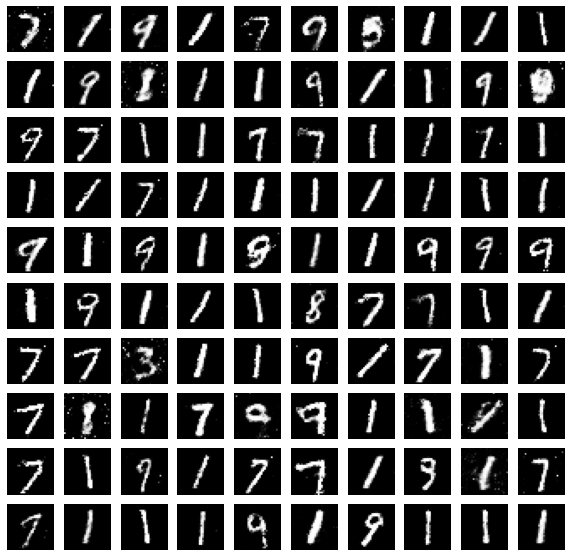

In [ ]:
generator = Generator()
path="gdrive/My Drive/Colab Notebooks/Scripts/"
run_id='51d64056-2f78-46d8-9dda-6c6b00ea637e'
generator.load_state_dict(torch.load(f'{path}GAN_runs/{run_id}/generator_49.pth'))
n=100

images = []
noise = generate_noise(n, device=get_device())
generator.eval()
images = generator(noise)
plt.figure(figsize=(10, 10))
for i in range(n):
  image = images[i]
  image = image.cpu().detach().numpy()
  image = np.reshape(image, (28, 28))
  im = Image.fromarray(image)
  plt.subplot(10, 10, i+1)
  plt.imshow(image, cmap='gray')
  plt.axis('off')
  plt.imsave(f"{path}Images/GAN_sample/GAN_{i}.jpeg",image, cmap='gray')